# Hawkes LSTM model

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

import torch
from torch import nn

import os
import sys
import glob
import tqdm
import pickle

In [3]:
SEED = 52
torch.manual_seed(SEED)

In [4]:
# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
print("Notebook dir {:}".format(nb_dir))
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
print("Python interpreter path:")
for path in sys.path:
    print(path)

Notebook dir /home/manifold/Documents/etudes/map511-p3a
Python interpreter path:
/home/manifold/Documents/etudes/map511-p3a/notebooks
/home/manifold/miniconda3/envs/pytorch/lib/python37.zip
/home/manifold/miniconda3/envs/pytorch/lib/python3.7
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/lib-dynload

/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/pointprocesses-0.4.1-py3.7-linux-x86_64.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg
/home/manifold/miniconda3/envs/pytorch/lib/python3.7/site-packages/IPython/extensions
/home/manifold/.ipython
/home/manifold/Documents/etudes/map511-p3a


## Loading synthetic data

We will be loading simulated Hawkes data.

In [5]:
SYNTH_DATA_FILES = glob.glob('../data/simulated/*.pkl')
print("Available files:")
for s in SYNTH_DATA_FILES:
    print(s)

from utils.load_synth_data import process_loaded_sequences

Available files:
../data/simulated/hawkes_synthetic_exp_2d_20181206-160527.pkl
../data/simulated/hawkes_synthetic_exp_1d_20181205-142133.pkl
../data/simulated/hawkes_synthetic_exp_2d_20181207-220402.pkl


In [8]:
# SET THESE PARAMETERS
process_dim = 2
print("Process dimension: {}".format(process_dim))
chosen_data_file = SYNTH_DATA_FILES[2]
print("Data file: {}".format(chosen_data_file))

Process dimension: 2
Data file: ../data/simulated/hawkes_synthetic_exp_2d_20181207-220402.pkl


In [9]:
# Load data simulated using tick
print("Loading {}-dimensional Hawkes data.".format(process_dim))

with open(chosen_data_file, "rb") as f:
    loaded_hawkes_data = pickle.load(f)

print(loaded_hawkes_data.keys())

mu = loaded_hawkes_data['mu']
alpha = loaded_hawkes_data['alpha']
decay = loaded_hawkes_data['decay']
tmax = loaded_hawkes_data['tmax']
print("mu\t{:}".format(str(mu)))
print("alpha\t{:}".format(str(alpha)))
print("decay\t{:}".format(str(decay)))
print("tmax\t{:}".format(tmax))

seq_times, seq_types, seq_lengths = process_loaded_sequences(
    loaded_hawkes_data, process_dim, tmax)

Loading 2-dimensional Hawkes data.
dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])
mu	[0.1 0.1]
alpha	[[0.1  0.01]
 [0.01 0.1 ]]
decay	1
tmax	3600


In [10]:
seq_times.shape

torch.Size([4000, 921])

In [11]:
loaded_hawkes_data.keys()

dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])

## Training

The intensity process is given by
$$
    \lambda_k(t) = f_k(\mathbf w_\alpha\mathbf h(t))
$$
with $\mathbf h(t)$ the hidden state, defined from the cell state $\mathbf c(t)$ :
$$
    \mathbf h(t) = \mathbf o_i \odot \tanh(\mathbf c(t))\in\mathbb R^D,\quad t\in(t_{i-1}, t_i].
$$
with
$$
    \mathbf c(t) = \bar{\mathbf c}_{i+1} + (\mathbf c_{i+1} - \bar{\mathbf c}_{i+1})\exp\left(-\delta_{i+1}(t-t_i)\right),\quad t\in(t_{i-1}, t_i].
$$

In [203]:
import models.ctlstm
from models.ctlstm import HawkesLSTM, HawkesLSTMGen
from train_functions import train_lstm, plot_loss

In [204]:
# define training data
train_size = 32
print("Train size %d" % train_size)

train_times_tensor = seq_times[:train_size]
train_seq_types = seq_types[:train_size]
train_seq_lengths = seq_lengths[:train_size]
print("Train event times shape {}".format(train_times_tensor.shape))
print("Train event types shape {}".format(train_seq_types.shape))
print("Train seq lengths shape {}".format(train_seq_lengths.shape))

Train size 32
Train event times shape torch.Size([32, 924])
Train event types shape torch.Size([32, 924])
Train seq lengths shape torch.Size([32])


In [206]:
process_dim = 1
hidden_size = 24
model = HawkesLSTM(process_dim, hidden_size)
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.05)

In [ ]:
# Training parameters
BATCH_SIZE = 32
EPOCHS = 1

loss_hist, train_hist = train_lstm(model, optimizer, train_times_tensor,
                                   train_seq_types, train_seq_lengths, tmax,
                                   BATCH_SIZE, EPOCHS, use_jupyter=True)

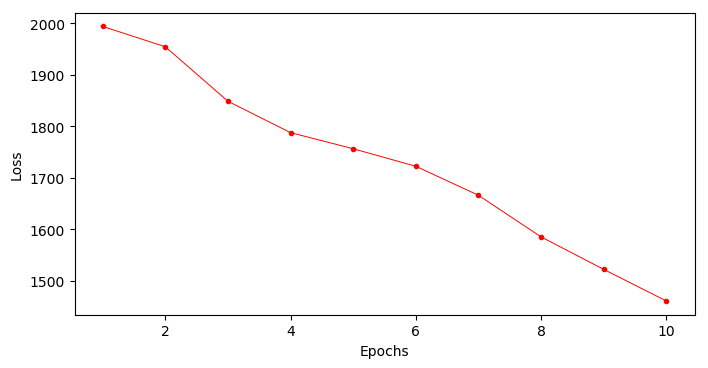

In [20]:
_ = plot_loss(EPOCHS, loss_hist)

In [15]:
import datetime
# Generate save params to record the model
# Model file dump
SAVED_MODELS_PATH = '../saved_models'
os.makedirs(SAVED_MODELS_PATH, exist_ok=True)
# print("Saved models directory: {}".format(SAVED_MODELS_PATH))

In [16]:
# This cell resets the timestamp !!
date_format = "%Y%m%d-%H%M%S"
now_timestamp = datetime.datetime.now().strftime(date_format)
extra_tag = "{}d".format(process_dim)

Now we save the model down to a file.

In [18]:
from utils.save_model import save_model

save_model(model, chosen_data_file, extra_tag, hidden_size, now_timestamp)

Saving model to: saved_models/HawkesLSTM-1d_hidden16-20181204-142925.pth
{'model_path': 'saved_models/HawkesLSTM-1d_hidden16-20181204-142925.pth', 'data_path': '../data/simulated/hawkes_synthetic_exp_1d_20181202-135203.pkl'}


# Model evaluation

Now we perform model evaluation steps.

## Load saved model

In [48]:
from models.ctlstm import HawkesLSTM, HawkesLSTMGen

In [49]:
MODEL_FILES = glob.glob("../saved_models/*.pth")
for p in MODEL_FILES:
    print(p)

../saved_models/HawkesLSTM-2d_hidden128-20181209-132611.pth
../saved_models/HawkesLSTM-1d_hidden64-20181206-235311.pth
../saved_models/HawkesDecayRNN-2d_hidden128-20181209-132014.pth
../saved_models/HawkesDecayRNN-1d_hidden64-20181206-234848.pth


In [50]:
load_filename = MODEL_FILES[0]
print("chosen file:", load_filename)

load_file_timestamp = "-".join(os.path.splitext(os.path.basename(load_filename))[0].split('-')[-2:])
print("Timestamp:", load_file_timestamp)

chosen file: ../saved_models/HawkesLSTM-2d_hidden128-20181209-132611.pth
Timestamp: 20181209-132611


In [51]:
process_dim = 2
hidden_size = 128
print("Hidden size: {}".format(hidden_size))
model = HawkesLSTM(process_dim, hidden_size)

model.load_state_dict(torch.load(load_filename, map_location={"cuda:0": "cpu"}))

Hidden size: 128


## Sequence generation

In [233]:
tmax = 3600  # real end time value

#### Generating sequences on untrained model with random weights

In [189]:
model2 = HawkesLSTM(2, hidden_size)
generator2 = HawkesLSTMGen(model2)

Process model dim:	2	Hidden units:	64


no. of events: 80
0: type 0
1: type 1


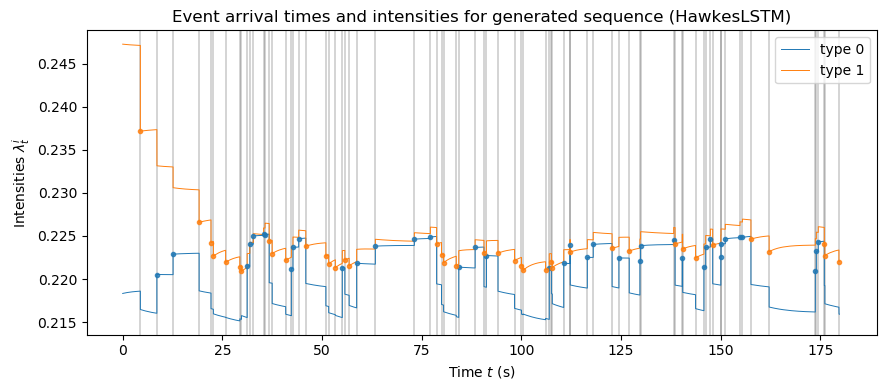

In [190]:
tmax_simu = 180
generator2.generate_sequence(tmax_simu, record_intensity=True)

fig = generator2.plot_events_and_intensity(debug=False)
fig.tight_layout()

In [191]:
fig.savefig('example_lstmplot__.pdf')

#### Sequence generation on trained model

In [52]:
from models.ctlstm import HawkesLSTM, HawkesLSTMGen

In [53]:
MODEL_NAME = model.__class__.__name__

In [54]:
generator = HawkesLSTMGen(model)

Process model dim:	2	Hidden units:	128


no. of events: 29
0: type 0
1: type 1


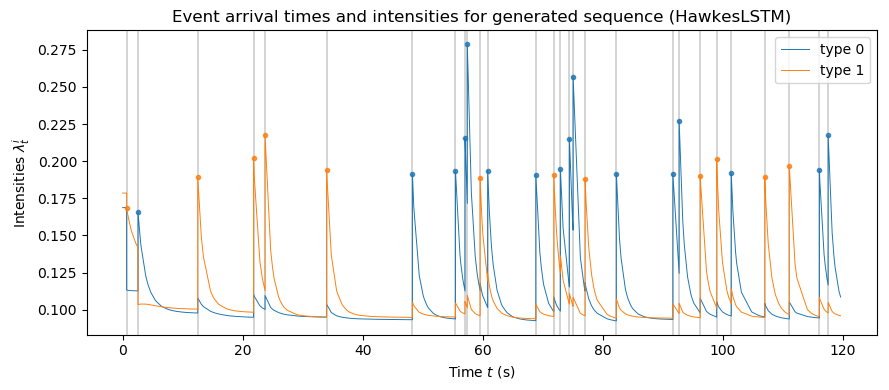

In [59]:
tmax_simu = 120

generator.generate_sequence(tmax_simu, record_intensity=True, mult_ub=20)
fig_ev_stream = generator.plot_events_and_intensity(debug=False)

In [60]:
fig_ev_stream.savefig("../results/intensity_{}_{}d_hidden{}_{}.pdf".format(
    MODEL_NAME, process_dim, hidden_size, load_file_timestamp))

### Length distribution

In [22]:
RESULT_BASEDIR = "../results"

MODEL_NAME = model.__class__.__name__
print(MODEL_NAME)

HawkesLSTM


In [23]:
from utils import evaluation

In [24]:
n_gen_seq = 1000

In [25]:
gen_seq_lengths, gen_seq_types_lengths = evaluation.generate_multiple_sequences(generator, tmax, n_gen_seq)

Mean generated sequence length: 721.292
Generated sequence length std. dev: 27.47181712228006


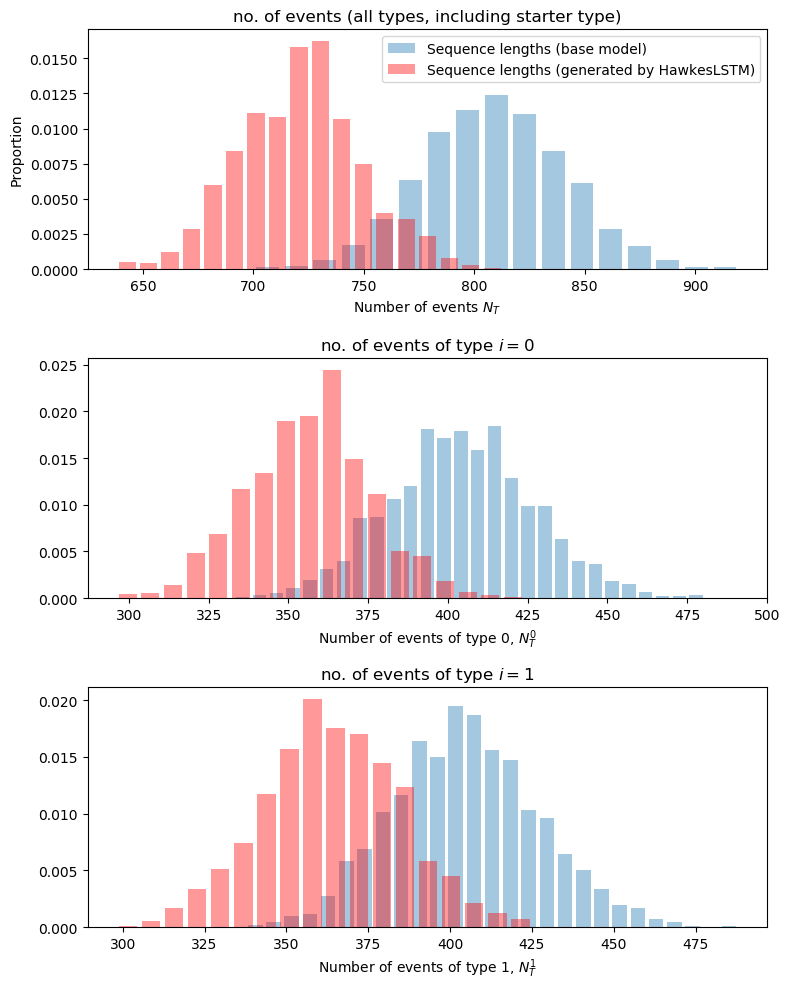

In [46]:
if process_dim > 1:
    num_plots = process_dim + 1
else:
    num_plots = 1
fig, axes = plt.subplots(num_plots, 1, figsize=(8,4+(num_plots-1)*3), dpi=100)
ax0 = axes[0] if num_plots > 1 else axes
hist_opts = {
    "rwidth": 0.8,
    "alpha": 0.4,
    "density": True
}
gen_label = "Sequence lengths (generated by {:})".format(MODEL_NAME)
_ = ax0.hist(seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            label="Sequence lengths (base model)",
            **hist_opts)
_ = ax0.hist(gen_seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            label=gen_label,
            color='red', **hist_opts)
ax0.legend()
if num_plots > 1:
    ax0.set_title('no. of events (all types, including starter type)')
else:
    ax0.set_title('no. of  events')
ax0.set_ylabel('Proportion')
ax0.set_xlabel('Number of events $N_T$')
if num_plots > 1:
    axt = axes[1:]
    for i, ax in enumerate(axt):
        # get the sequence lengths for the event types
        typ_seq_lengths = (seq_types == i).sum(dim=1)
        gen_typ_seq_lengths = gen_seq_types_lengths[:, i]
        ax.hist(typ_seq_lengths, bins=2*int(typ_seq_lengths.size(0)**(1/3)),
                label="Sequence lengths (base model)",
                **hist_opts)
        ax.hist(gen_typ_seq_lengths,
                bins=2*int(gen_typ_seq_lengths.shape[0]**(1/3)),
                label=gen_label,
                color='red', **hist_opts)
        ax.set_xlabel("Number of events of type {}, $N_T^{}$".format(i, i))
        ax.set_title('no. of events of type $i={}$'.format(i))

fig.tight_layout()

In [47]:
os.makedirs(RESULT_BASEDIR, exist_ok=True)
model_perf_indicator = "length_distrib"
distrib_plot_filepath = "{:}/{:}_{:}-{}d-hidden{}-{}.pdf".format(
    RESULT_BASEDIR, model_perf_indicator, MODEL_NAME,
    process_dim, model.hidden_size, load_file_timestamp)
fig.savefig(distrib_plot_filepath)

## Event prediction

In [62]:
from models.ctlstm import read_predict
import tqdm

In [63]:
dataset_size = seq_times.shape[0]
print(dataset_size)

train_size = 3000
test_size = 1000

4000


3450
last event: time 3595.294 type 0.000
next event: time 3599.027 type 1.000, in 3.733
type probabilities: tensor([0.4859, 0.4996])
(tensor(2.6219), tensor(3.7327), tensor(1.2338), tensor(1), tensor(1))


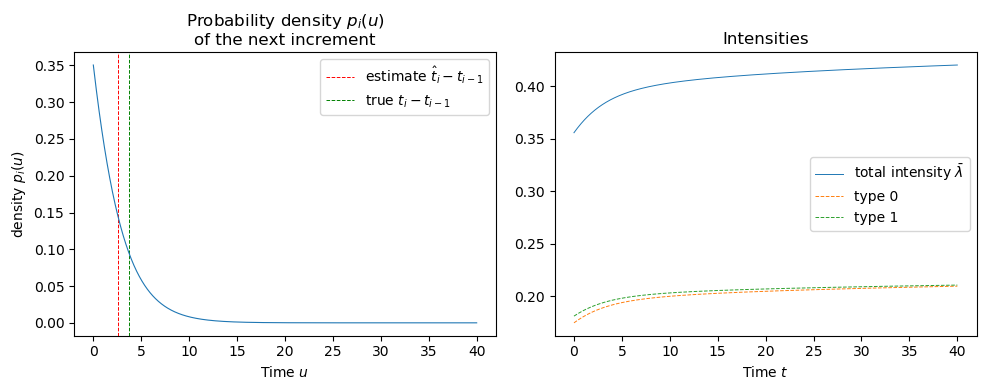

In [72]:
my_index = torch.randint(0, 4000, (1,)).int().item()
print(my_index)

_seq_data = (seq_times[my_index],
             seq_types[my_index],
             seq_lengths[my_index])
restup, fig = read_predict(model, *_seq_data,
                           plot=True, print_info=True)
print(restup)
fig.tight_layout()

In [73]:
fig.savefig('lstm_{}d_prediction_graphs_hidden{}_NEW.pdf'
            .format(process_dim, hidden_size))

In [31]:
seq_times.shape

torch.Size([4000, 921])

In [74]:
estimates = []
real_incrs = []
errors = []
real_types = []
est_types = []
index_range_ = tqdm.tnrange(3000, 3000+test_size)
for index_ in index_range_:
    _seq_data = (seq_times[index_],
                 seq_types[index_],
                 seq_lengths[index_])

    est, real_dt, err, real_type, est_type = read_predict(model, *_seq_data)
    estimates.append(est)
    real_incrs.append(real_dt)
    errors.append(err)
    real_types.append(real_type)
    est_types.append(est_type)

Now we save the prediction results to a file

In [86]:
RESULT_BASEDIR = "../results"

MODEL_NAME = model.__class__.__name__
print(MODEL_NAME)

HawkesLSTM


In [87]:
import json

In [88]:
avg_rmse = np.sqrt(np.mean(errors), dtype=np.float64)
print(avg_rmse)

mse_var = np.var(errors, dtype=np.float64)
print(mse_var)

delta_meth_stderr = 1/test_size*mse_var/(4*avg_rmse)
print(delta_meth_stderr)

5.692733871621391
7355.487308547297
0.32302086635451327


In [89]:
real_types = np.array(real_types)
est_types = np.array(est_types)

error_types = np.mean((real_types - est_types) == 0)
print(error_types)

0.503


In [90]:
from sklearn.metrics import confusion_matrix

In [93]:
confusion_matrix(real_types, est_types)

array([[264, 267],
       [230, 239]])

In [94]:
seq_times[:train_size].numel()

2763000

In [95]:
predict_data = {
    "model_name": MODEL_NAME,
    "process_dim": process_dim,
    "hidden_size": hidden_size,
    "data_file": chosen_data_file,
    "avg_rmse": avg_rmse,
    "var_mse": mse_var,
    "std_rmse": delta_meth_stderr,
    "error_types": error_types,
    "model_timestamp": load_file_timestamp
}

predict_data

{'model_name': 'HawkesLSTM',
 'process_dim': 2,
 'hidden_size': 128,
 'data_file': '../data/simulated/hawkes_synthetic_exp_2d_20181207-220402.pkl',
 'avg_rmse': 5.692733871621391,
 'var_mse': 7355.487308547297,
 'std_rmse': 0.32302086635451327,
 'error_types': 0.503,
 'model_timestamp': '20181209-132611'}

In [96]:
predict_res_file = "predict_results.json"

In [97]:
predict_data.keys()

dict_keys(['model_name', 'process_dim', 'hidden_size', 'data_file', 'avg_rmse', 'var_mse', 'std_rmse', 'error_types', 'model_timestamp'])

In [103]:
with open(predict_res_file, "r+", encoding='utf-8', newline='\n') as fp:
    try:
        data = json.load(fp)
    except json.JSONDecodeError:
        data = []
    data.append(predict_data)
    fp.seek(0)
    json.dump(data, fp, indent=4)
    fp.write('\n')